In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [ ]:
data = pd.read_csv('ethusd_tweets.csv')[::-1]

In [ ]:
# Define the number of data points to consider
data_points = 360

# Extract specific columns from the dataset and convert to numeric values
high_prices = pd.to_numeric(data['High'][-data_points:])
low_prices = pd.to_numeric(data['Low'][-data_points:])
open_prices = pd.to_numeric(data['Open'][-data_points:])
closing_prices = pd.to_numeric(data['Close'][-data_points:])
tweet_counts = pd.to_numeric(data['Tweets'].replace('null', 0)[-data_points:])
volumes = pd.to_numeric(data['Volume'][-data_points:])
market_caps = pd.to_numeric(data['Market Cap'][-data_points:])

# Store a copy of the original closing prices
original_closing_prices = closing_prices

# Perform percentage change calculations and handle missing or infinite values
high_prices = high_prices.pct_change().replace(np.nan, 0).replace(np.inf, 0)
low_prices = low_prices.pct_change().replace(np.nan, 0).replace(np.inf, 0)
open_prices = open_prices.pct_change().replace(np.nan, 0).replace(np.inf, 0)
closing_prices = closing_prices.pct_change().replace(np.nan, 0).replace(np.inf, 0)
tweet_counts = tweet_counts.pct_change().replace(np.nan, 0).replace(np.inf, 0)
volumes = volumes.pct_change().replace(np.nan, 0).replace(np.inf, 0)
market_caps = market_caps.pct_change().replace(np.nan, 0).replace(np.inf, 0)

# Convert processed data into NumPy arrays for further analysis
original_closing_prices = np.array(original_closing_prices)
high_prices = np.array(high_prices)
low_prices = np.array(low_prices)
open_prices = np.array(open_prices)
closing_prices = np.array(closing_prices)
tweet_counts = np.array(tweet_counts)
volumes = np.array(volumes)
market_caps = np.array(market_caps)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Define window size, step, and forecast values for data processing
window_size = 7
step_size = 1
forecast_value = 1

# Initialize lists to store input (X) and output (Y) data
input_data, output_data = [], []

# Iterate over the data considering the step size
for i in range(0, len(open_prices), step_size): 
    try:
        open_window = open_prices[i:i+window_size]
        high_window = high_prices[i:i+window_size]
        low_window = low_prices[i:i+window_size]
        close_window = closing_prices[i:i+window_size]
        volume_window = volumes[i:i+window_size]
        tweet_window = tweet_counts[i:i+window_size]
        marketcap_window = market_caps[i:i+window_size]
        
        # Calculate the forecasted value for output Y
        y_i = closing_prices[i+window_size+forecast_value]
        
        # Prepare input X by stacking the windows of data
        x_i = np.column_stack((open_window, high_window, low_window, close_window, 
                               volume_window, tweet_window, marketcap_window))
        x_i = x_i.flatten()

    except Exception as e:
        break

    input_data.append(x_i)
    output_data.append(y_i)

# Convert input and output data to NumPy arrays
input_data, output_data = np.array(input_data), np.array(output_data)


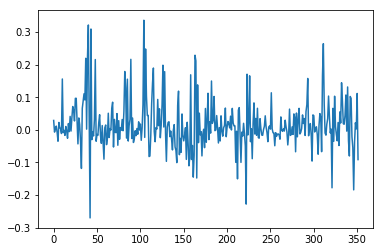

In [ ]:
plt.figure()
plt.plot(output_data)
plt.show()

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def create_simple_model(input_size):
    # Define the input layer
    input_layer = Input(shape=(input_size, ), name='input_layer')
    
    # Add a dense layer with 25 units and linear activation
    dense_layer = Dense(25, activation='linear')(input_layer)
    
    # Output layer with a single unit and linear activation
    output_layer = Dense(1, activation="linear", name="output_layer")(dense_layer)
    
    # Create the final model using the defined layers
    model = Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile the model with the Adam optimizer and mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define callbacks for reducing learning rate and model checkpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)

# Splitting data into training and testing sets
X_train, Y_train = input_data[:-30], output_data[:-30]
X_test, Y_test = input_data[-30:], output_data[-30:]

# Creating the model using the previously defined function
model = create_simple_model(len(X_train[0]))

# Fitting the model with training data, validating on test data
history = model.fit(X_train, Y_train, 
                    epochs=100, 
                    batch_size=64, 
                    verbose=1, 
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)


Train on 322 samples, validate on 30 samples
Epoch 1/100
322/322 [==============================] - 0s - loss: 0.3210 - val_loss: 0.1768
Epoch 2/100
322/322 [==============================] - 0s - loss: 0.2467 - val_loss: 0.1585
Epoch 3/100
322/322 [==============================] - 0s - loss: 0.1946 - val_loss: 0.1426
Epoch 4/100
322/322 [==============================] - 0s - loss: 0.1560 - val_loss: 0.1331
Epoch 5/100
322/322 [==============================] - 0s - loss: 0.1261 - val_loss: 0.1222
Epoch 6/100
322/322 [==============================] - 0s - loss: 0.1025 - val_loss: 0.1110
Epoch 7/100
322/322 [==============================] - 0s - loss: 0.0832 - val_loss: 0.1038
Epoch 8/100
322/322 [==============================] - 0s - loss: 0.0729 - val_loss: 0.0983
Epoch 9/100
322/322 [==============================] - 0s - loss: 0.0636 - val_loss: 0.0890
Epoch 10/100
322/322 [==============================] - 0s - loss: 0.0564 - val_loss: 0.0798
Epoch 11/100
322/322 [============

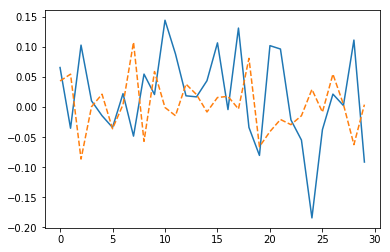

(322, 49) (30, 49) (322,) (30,)
0.0075026394634859035
0.06918683376091657


In [ ]:
# Load the weights into the model
model.load_weights('testtest.hdf5')

# Predict using the test data
pred = model.predict(X_test)
predicted = pred
original = Y_test

# Plotting the original and predicted values
plt.plot(original)
plt.plot(predicted, linestyle='--')
plt.show()

# Printing the shapes of training and test data
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Calculating mean squared error and mean absolute error
mse = np.mean(np.square(predicted - original))
mae = np.mean(np.abs(predicted - original))
print(mse)
print(mae)


In [ ]:
import tensorflow as tf

# Create a session and initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

dense_weights, out_weights = None, None

# Iterate through the model layers to extract weights
for layer in model.layers:
    if len(layer.weights) > 0:
        weights = layer.get_weights()
        if 'dense' in layer.name:
            dense_weights = sess.run(layer.weights[0])
        if 'out' in layer.name:
            out_weights = sess.run(layer.weights[0])


In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI
from pyro.optim import Adam

pyro.get_param_store().clear()

In [ ]:
import torch
from torch.autograd import Variable

# Convert data to PyTorch Variables
X_train, Y_train = Variable(torch.Tensor(X[:-30])), Variable(torch.Tensor(Y[:-30]))
X_test, Y_test = Variable(torch.Tensor(X[-30:])), Variable(torch.Tensor(Y[-30:]))
data = torch.cat((X_train, Y_train), 1)

In [ ]:
import torch
import torch.nn as nn

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)


In [ ]:
def model(data):
    mu = torch.zeros(second_layer, first_layer).type_as(data)
    sigma = torch.ones(second_layer, first_layer).type_as(data)
    bias_mu = torch.zeros(second_layer).type_as(data)
    bias_sigma = torch.ones(second_layer).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = torch.zeros(1, second_layer).type_as(data)
    sigma2 = torch.ones(1, second_layer).type_as(data)
    bias_mu2 = torch.zeros(1).type_as(data)
    bias_sigma2 = torch.ones(1).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, torch.ones(data.size(0)).type_as(data)),
                    obs=y_data.squeeze())
        


In [ ]:
  
def guide(data):
    w_mu = torch.randn(second_layer, first_layer).type_as(data.data).requires_grad_()
    w_log_sig = 0.1 * torch.ones(second_layer, first_layer).type_as(data.data).requires_grad_()
    b_mu = torch.randn(second_layer).type_as(data.data).requires_grad_()
    b_log_sig = 0.1 * torch.ones(second_layer).type_as(data.data).requires_grad_()
    
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    w_mu2 = torch.randn(1, second_layer).type_as(data.data).requires_grad_()
    w_log_sig2 = 0.1 * torch.randn(1, second_layer).type_as(data.data).requires_grad_()
    b_mu2 = torch.randn(1).type_as(data.data).requires_grad_()
    b_log_sig2 = 0.1 * torch.ones(1).type_as(data.data).requires_grad_()
    
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    lifted_module = pyro.random_module("module", regression_model, dists)
    return lifted_module()


In [ ]:
optimizer = Adam({"lr": 0.001})
svi = SVI(model, guide, optimizer, loss="ELBO")

num_samples = len(X_train)

for epoch in range(3000):
    total_loss = 0.0
    permutation = torch.randperm(num_samples)
    # shuffle data
    shuffled_data = data[permutation]
    # get batch indices
    all_batches = get_batch_indices(num_samples, 64)
    for idx, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[idx + 1]
        batch_data = shuffled_data[batch_start: batch_end]        
        total_loss += svi.step(batch_data)
    if epoch % 100 == 0:
        print(epoch, "average loss {}".format(total_loss / float(num_samples)))


(0, 'avg loss 991.628272394')
(100, 'avg loss 441.582249612')
(200, 'avg loss 314.615231342')
(300, 'avg loss 295.246842852')
(400, 'avg loss 243.860453161')
(500, 'avg loss 137.239890152')
(600, 'avg loss 88.3047235145')
(700, 'avg loss 162.848065678')
(800, 'avg loss 121.565960428')
(900, 'avg loss 69.0251002341')
(1000, 'avg loss 82.692127678')
(1100, 'avg loss 48.7133728406')
(1200, 'avg loss 45.6457220042')
(1300, 'avg loss 35.0357700135')
(1400, 'avg loss 33.2322527962')
(1500, 'avg loss 34.6992970342')
(1600, 'avg loss 26.8403509863')
(1700, 'avg loss 22.6639203374')
(1800, 'avg loss 18.9730090029')
(1900, 'avg loss 16.0454520468')
(2000, 'avg loss 15.0732588679')
(2100, 'avg loss 14.869928206')
(2200, 'avg loss 12.4058045571')
(2300, 'avg loss 12.0039140216')
(2400, 'avg loss 10.9979856503')
(2500, 'avg loss 10.3619899394')
(2600, 'avg loss 9.91170222122')
(2700, 'avg loss 9.61216157712')
(2800, 'avg loss 9.24607062488')
(2900, 'avg loss 8.75313279051')


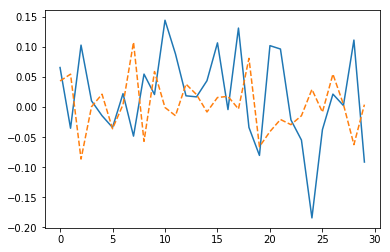

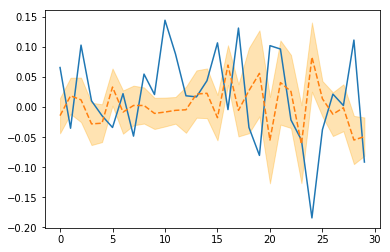

In [ ]:
predictions = []
for i in range(100):
    sampled_reg_model = guide(X_test)
    prediction = sampled_reg_model(X_test).data.numpy().flatten()
    predictions.append(prediction)

predictions = np.array(predictions)
mean_prediction = np.mean(predictions, axis=0)
std_deviation = np.std(predictions, axis=0) / 10
true_values = Y_test.data.numpy()
x_axis = np.arange(len(true_values))

plt.figure()
plt.plot(original)
plt.plot(predicted, linestyle='--')
plt.show()

plt.figure()
plt.plot(x_axis, true_values)
plt.plot(x_axis, mean_prediction, linestyle='--')
plt.fill_between(x_axis, mean_prediction - std_deviation, mean_prediction + std_deviation, alpha=0.3, color='orange')
plt.show()


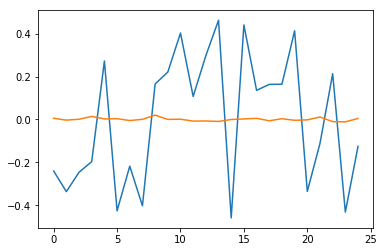

In [ ]:
plt.figure()
plt.plot(out_weights)
plt.plot(pyro.param('guide_mean_weight2').data.numpy()[0])
plt.show()


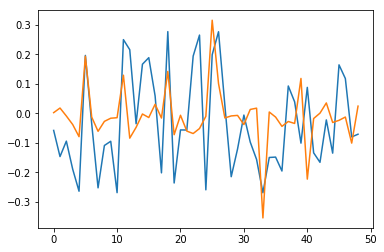

In [ ]:
plt.figure()
plt.plot(dense_weights.T[14])
plt.plot(pyro.param('guide_mean_weight').data.numpy()[10])
plt.show()